Import

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Mount Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Dataset Loading: Total Images and Total Masks

In [ ]:
def load_dataset(path):
  images = sorted(glob(os.path.join(path, 'Image', '*')))
  masks = sorted(glob(os.path.join(path, 'Annotation', '*')))
  return images, masks

Dataset Split


In [ ]:
def split_dataset(images, masks, split=0.2):
  split_size = int(len(images) * split)
  train_x, valid_x = train_test_split(images, test_size=100, random_state=42)
  train_y, valid_y = train_test_split(masks, test_size=100, random_state=42)

  train_x, test_x = train_test_split(images, test_size=split_size, random_state=42)
  train_y, test_y = train_test_split(masks, test_size=split_size, random_state=42)

  return (train_x, train_y), (test_x, test_y), (valid_x, valid_y)

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
def save_dataset(images, masks, save_dir):
    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1]
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        save_image_path = os.path.join(save_dir, "Images", name)
        save_mask_path = os.path.join(save_dir, "Masks", name)

        cv2.imwrite(save_image_path, x)
        cv2.imwrite(save_mask_path, y)

In [ ]:
train_test_path="/content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train"
project_dir = "/content/drive/MyDrive/Project"

In [ ]:
images, masks = load_dataset(train_test_path)
print(f"Total Images: {len(images)} - Total Masks: {len(masks)}")

Images: 1030 - Masks: 1030
Validation Images: 100 - Validation Masks: 100


In [ ]:
for x, y in zip(images, masks):
  print(x, y)

/content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Image/10657.png /content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Annotation/10657.png
/content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Image/10671.png /content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Annotation/10671.png
/content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Image/10682.png /content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Annotation/10682.png
/content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Image/10690.png /content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Annotation/10690.png
/content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Image/10694.png /content/drive/MyDrive/Project/Resized_Ischemia_dataset_annotated_256/Train/Annotation/10694.png
/content/drive/MyDrive/Project/Resized_Ischemia_dataset

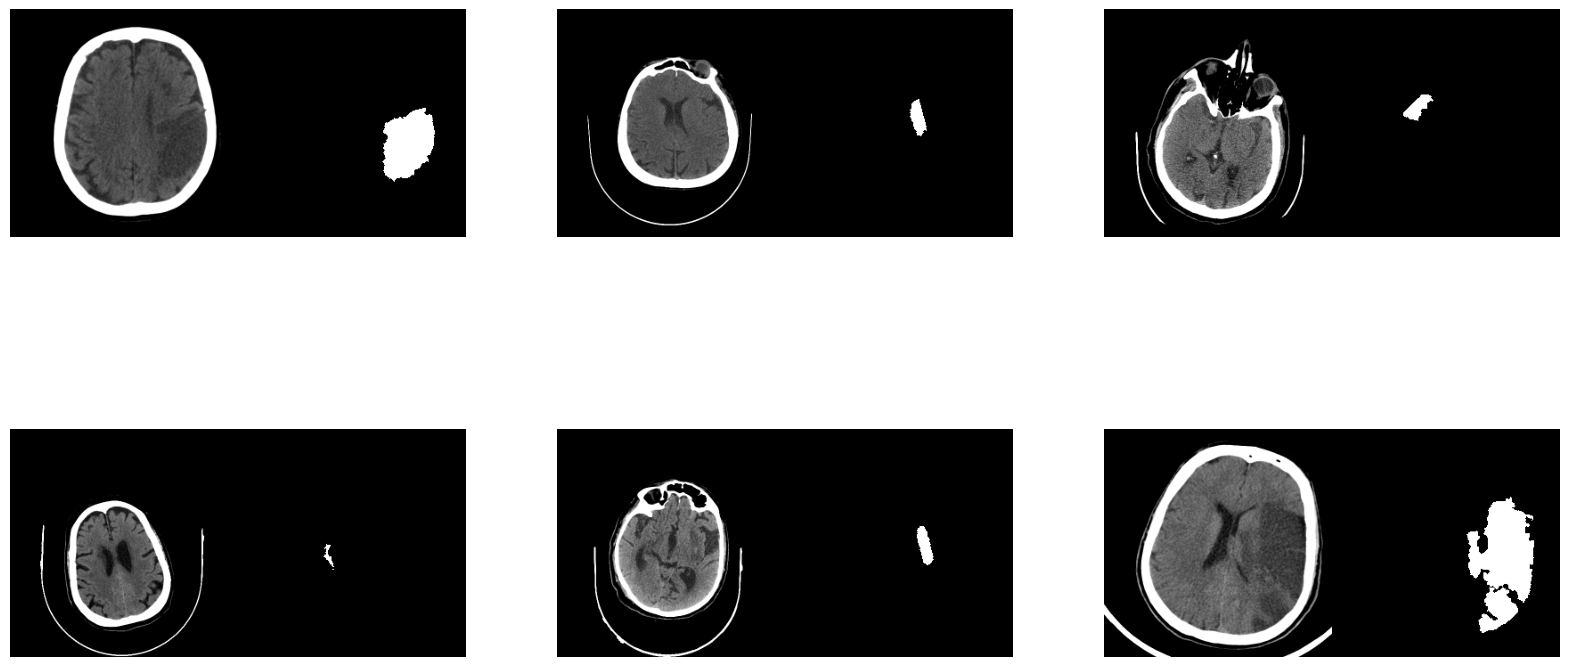

In [ ]:
!pip install imshowtools
from imshowtools import imshow
image_list = []
for x, y in zip(images[:6], masks[:6]):
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  y = cv2.imread(y, cv2.IMREAD_COLOR)
  z = np.concatenate([x, y], axis=1)
  image_list.append(z)

imshow(*image_list, size=(20, 10), columns = 3)

In [ ]:
(train_x, train_y), (test_x, test_y), (valid_x, valid_y) = split_dataset(images, masks, 0.1)

In [ ]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 927 - 927
Valid: 100 - 100
Test : 103 - 103


In [ ]:
save_dir = os.path.join(project_dir, "dataset", "non-aug")
for item in ["Train", "Valid", "Test"]:
    create_dir(os.path.join(save_dir, item, "Images"))
    create_dir(os.path.join(save_dir, item, "Masks"))

In [ ]:
save_dataset(train_x, train_y, os.path.join(save_dir, "Train"))
save_dataset(test_x, test_y, os.path.join(save_dir, "Test"))
save_dataset(valid_x, valid_y, os.path.join(save_dir, "Valid"))

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Input,Conv2D,Rescaling
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPool2D, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.listdir("/content/drive/MyDrive/Project")

['Resized_Ischemia_dataset_annotated_256.zip',
 'Resized_Ischemia_dataset_annotated_256',
 'dataset',
 'files',
 'validation',
 'old',
 'Validation.ipynb',
 'old_college_1',
 'Segmentation3.ipynb']

In [ ]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
""" Hyperparameters """
batch_size = 8
lr = 1e-4
height=256
width=256
num_epochs = 100

In [ ]:
project_dir="/content/drive/MyDrive/Project"
dataset_path = os.path.join(project_dir, "dataset", "non-aug")
files_dir = os.path.join(project_dir, "files", "non-aug")
model_file = os.path.join(files_dir, "unet-non-aug.h5")
log_file = os.path.join(files_dir, "log-unet-non-aug.csv")

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir(files_dir)

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
#Encoder Block
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [ ]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "Train", "Images", "*")))
    train_y = sorted(glob(os.path.join(path, "Train", "Masks", "*")))

    test_x = sorted(glob(os.path.join(path, "Test", "Images", "*")))
    test_y = sorted(glob(os.path.join(path, "Test", "Masks", "*")))

    # valid_x, glob(os.path.join(path, "Valid", "Images", "*"))
    # valid_y, glob(os.path.join(path, "Valid", "Masks", "*"))
    return (train_x, train_y), (test_x, test_y)

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    return x

In [ ]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x / 255.0               ## (h, w)
    # x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

In [ ]:
def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
(train_x, train_y), (test_x, test_y) = load_data(dataset_path)
print(train_x[0], " - ", train_y[0])
print(test_x[0], " - ", test_y[0])

/content/drive/MyDrive/Project/dataset/non-aug/Train/Images/10657.png  -  /content/drive/MyDrive/Project/dataset/non-aug/Train/Masks/10657.png
/content/drive/MyDrive/Project/dataset/non-aug/Test/Images/10690.png  -  /content/drive/MyDrive/Project/dataset/non-aug/Test/Masks/10690.png


In [ ]:
print(f"Train: {len(train_x)} - {len(train_y)}")
# print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

Train: 927 - 927
Test : 103 - 103


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [ ]:
# for x, y in train_dataset:
#     print(x.shape, y.shape)

In [ ]:
input_shape = (height, width, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [ ]:
!pip install -U segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics = [sm.metrics.IOUScore(class_indexes=np.array([0])),sm.metrics.FScore(threshold=0.1,class_indexes=np.array([0])), 'acc'])

callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=False),
]


Segmentation Models: using `tf.keras` framework.


In [ ]:
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 0.2858 - iou_score: 0.0268 - f1-score: 0.0405 - acc: 0.9360
Epoch 1: val_loss improved from inf to 0.51151, saving model to /content/drive/MyDrive/Project/files/non-aug/unet-non-aug.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 745s 6s/step - loss: 0.2858 - iou_score: 0.0268 - f1-score: 0.0405 - acc: 0.9360 - val_loss: 0.5115 - val_iou_score: 0.0280 - val_f1-score: 0.0454 - val_acc: 0.9076 - lr: 1.0000e-04
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 0.1469 - iou_score: 0.0370 - f1-score: 0.0917 - acc: 0.9799
Epoch 2: val_loss improved from 0.51151 to 0.23535, saving model to /content/drive/MyDrive/Project/files/non-aug/unet-non-aug.h5
116/116 [==============================] - 69s 596ms/step - loss: 0.1469 - iou_score: 0.0370 - f1-score: 0.0917 - acc: 0.9799 - val_loss: 0.2354 - val_iou_score: 0.0263 - val_f1-score: 0.0454 - val_acc: 0.9768 - lr: 1.0000e-04
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 0.1229 - iou_score: 0.0492 - f1-score: 0.2008 - acc: 0.9804
Epoch 3: val_loss improved from 0.23535 to 0.15689, saving model to /content/drive/MyDrive/Project/files/non-aug/unet-non-aug.h5
116/116 [===================

In [ ]:
model.save('/content/drive/MyDrive/Project/files/non-aug/final_unet_model.h5')